<a id='top'></a>

<p style="
   font-size : 16px; 
   background-color: #ececec; 
   border-bottom-left-radius: 10px;
   border-bottom-right-radius: 10px;
   border-top-left-radius: 10px;
   border-top-right-radius: 10px;
   padding: 10px
   "
>
This notebook is about quickly and gently introducing the reader to state of the art NLP. To do this, we start with the basics of data preparation and a little text mining. After that we continue with neural networks, especially LSTM. First, a basic model will be created and then all further results will be compared to it. After describing the weaknesses of simple LSTM models, we turn to several possible solutions. These include Unsupervised Embeddings (Word2Vec) and Transformers. Everything is explained intuitively in an application-oriented way. Those who work through this notebook will be able to apply all the topics covered in the end. Have fun working through it.
</p>
<br>
 
<p style="font-size : 16px">For demonstartion purposes, the disaster tweet dataset is used. So we distinguish fake news from real news. To do this, we train a model that can make this distinction. The trained model is then applied to an unknown dataset. We start with a short section about text mining. After that, different concepts from N-grams to embeddings to transformers are contrasted.</p>

<img height="400" width="400" src="https://www.inside-digital.de/img/was-zum-henker-will-der-tesla-chef-mit-twitter-1200x900.jpg">
<p style="font-size : 12px"><em>Image from: <a href="https://theelectionnetwork.com/wp-content/uploads/2019/01/fake-news-1024x670.png">here</a></em></p>
<p style="font-size : 18px">If you want to have a R based tutorial you can look <a href="https://www.kaggle.com/frankmollard/nlp-basics-tutorial">here</a>.</p>

<div class="list-group" id="list-tab" role="tablist">
<h3 data-toggle="list"  role="tab" aria-controls="home"><p style="font-size : 30px"><font color="darkgrey">Content<font/><p/><h3/>
    
1. [<font color="darkgrey">Introduction<font/>](#1)   
    - 1.1 [<font color="darkgrey">Data Preparation<font/>](#1.1)
    - 1.2 [<font color="darkgrey">Text Mining with Word Cloud<font/>](#1.2)
    - 1.3 [<font color="darkgrey">Text Mining with Frequency Plots<font/>](#1.3)    
    - 1.4 [<font color="darkgrey">Prepare Text for ML<font/>](#1.4)
        - 1.4.1 [<font color="darkgrey">N-Grams<font/>](#1.4.1)
        - 1.4.2 [<font color="darkgrey">Tokenization<font/>](#1.4.2)
        - 1.4.3 [<font color="darkgrey">Padding<font/>](#1.4.3)
2. [<font color="darkgrey">LSTM<font/>](#2) 
    - 2.1 [<font color="darkgrey">Embeddings<font/>](#2.1)    
    - 2.2 [<font color="darkgrey">The Results of a Simple LSTM<font/>](#2.2)   
3. [<font color="darkgrey">Word2Vec with GenSim<font/>](#3) 
    - 3.1 [<font color="darkgrey">Word2Vec<font/>](#3.1)
    - 3.2 [<font color="darkgrey">LSTM with Context Synonyms<font/>](#3.2)
    - 3.3 [<font color="darkgrey">Submission Word2Vec Context Synonyms<font/>](#3.3)
    - 3.4 [<font color="darkgrey">Glove Embeddings with GenSim<font/>](#3.4)    
    - 3.5 [<font color="darkgrey">Submission Glove Embeddings<font/>](#3.5)      
4. [<font color="darkgrey">BERT<font/>](#4) 
    - 4.1 [<font color="darkgrey">Attention<font/>](#4.1)
    - 4.2 [<font color="darkgrey">Transformer<font/>](#4.2)    
    - 4.3 [<font color="darkgrey">Submission BERT Model<font/>](#4.3)    
6. [<font color="darkgrey">Voting<font/>](#6) 
7. [<font color="darkgrey">Conclusion<font/>](#7) 

<font size="+3" color="grey"><b>1. Introduction </b></font><br><a id="1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Text mining and natural language processing are not the same thing, but they do have overlap. The following table shows roughly what the differences are:</p>

![](https://miro.medium.com/max/475/1*bKz6UTji3SdDyb8-Pwm3Gg.png)

<p style="font-size : 12px"><em>Table from: <a href="https://medium.com/@emmanuel.balraj_57030/nlp-and-text-mining-374f7796a773">here</a></em></p>

<p style="font-size : 16px">What is not yet mentioned in the table is text classification. We will go through the individual steps below using the example and explain exactly how they work.</p>

<p style="font-size : 16px">First we import the important modules ad set seed:</p>

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import pandas as pd
import nltk
import re
!pip install contractions
import contractions
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge as R
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score as acu

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Bidirectional, Dense
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.math import rint, reduce_sum, divide, exp, subtract, greater_equal
from tensorflow.math import round as rounding
from tensorflow.random import set_seed
from tensorflow import cast, constant
from tensorflow.nn import softmax

!pip install plot-keras-history
from plot_keras_history import plot_history

from transformers import BertTokenizer, TFBertForSequenceClassification

import gensim
import gensim.downloader as api

seed = 111
np.random.seed(seed)
set_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<p style="font-size : 16px">Reading the text data and separating the target (y):</p>

In [4]:
train, test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing_with_Disaster_Tweets/Dataset/train.csv"), pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing_with_Disaster_Tweets/Dataset/test.csv")
y=train.target.values

<font size="+1" color="grey"><b>1.1 Data Preparation </b></font><br><a id="1.1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Emojis are not relevant for text analysis, i.e. text mining, so they should be removed. Since emojis are also context based and have a high intrinsic expressiveness, we also throw them out for NLP purposes.</p>

이모티콘은 텍스트 분석, 즉 텍스트 마이닝과 관련이 없으므로 제거되어야 합니다. 이모티콘도 문맥 기반이고 고유 표현력이 높기 때문에 NLP 목적으로도 이모티콘을 버린다.

In [5]:
emojis = ["\U0001F600", "\U0001F64F", "\U0001F300", "\U0001F5FF", "\U0001F680", "\U0001F6FF", "\U0001F1E0", "\U0001F1FF", "\U00002702", "\U000027B0", "\U000024C2", "\U0001F251"]
emojis

['😀', '🙏', '🌀', '🗿', '🚀', '\U0001f6ff', '\U0001f1e0', '🇿', '✂', '➰', 'Ⓜ', '🉑']

<p style="font-size : 16px">Stopwords are words with no specific meaning like "a", "the", or "by". It is important to remove them for text mining, but not for NLP. For neural networks that process sentences sequentially, such as 1D-CNN or RNN, stopwords are an important indicator of context.</p>
중지어는 "a", "the" 또는 "by"와 같은 특별한 의미가 없는 단어입니다. 텍스트 마이닝의 경우 이러한 파일을 제거하는 것이 중요하지만 NLP의 경우에는 제거되지 않습니다. 1D-CNN 또는 RNN과 같이 문장을 순차적으로 처리하는 신경망의 경우 중지어는 문맥의 중요한 지표이다.

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopWords = nltk.corpus.stopwords.words("english")

<p style="font-size : 16px">The regex tokenizer used here separates the words of a contiguous string into a list consisting of words only. "\w+" means that all word characters contiguous are turned into a list element.</p>
여기서 사용되는 정규식 토큰화기는 연속 문자열의 단어를 단어만으로 구성된 목록으로 구분합니다. "\w+"는 연속되는 모든 단어 문자가 목록 요소로 바뀐다는 것을 의미한다.

In [8]:
token = nltk.tokenize.RegexpTokenizer(r"\w+")

<p style="font-size : 16px">Stemming is a set of algorithms for determining the root of words. For example, the root of the words "paint", "painted", "painting" is the same. However, since algorithms are used, incorrect word stems can also be calculated. It is not uncommon to get results like "peopl" for "peoples" or "poeple". Depending on the algorithm, the stemming can also become too strong because too much is taken away from the word. In this case we talk about overstemming.</p>

<p style="font-size : 16px">An alternative approach is called lemmatization. Here the correct infinitive is taken from a stored guard book. This leads of course to the fact that not every word can be converted into its infinitive, since the lexicon is limited. In the following we use a lemmatization, because we want to build Wordclouds, which should contain real words.</p>

Stemming은 단어의 뿌리를 결정하기 위한 알고리즘 집합이다. 예를 들어, "paint", "painted" , "painting" 단어의 어근은 동일합니다. 그러나 알고리즘이 사용되기 때문에 잘못된 단어 줄기도 계산할 수 있다. "people" 또는 "peoples"에 대한 "peopl"과 같은 결과를 얻는 것은 드문 일이 아니다. 알고리즘에 따라 단어에서 너무 많은 것을 빼앗기 때문에 줄임말이 너무 강해질 수도 있다. 이 경우 우리는 overstamming이라 이야기한다.

대안적인 접근은 lemmatization이라고 불린다. 여기서 정확한 부정사는 저장된 방호책에서 가져온 것이다. 이것은 물론 어휘가 제한적이기 때문에 모든 단어가 부정사로 변환될 수 없다는 사실로 이어진다. 다음에서 우리는 레름화를 사용합니다. 왜냐하면 우리는 실제 단어를 포함해야 하는 워드 클라우드를 만들고 싶기 때문입니다.

In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()

<p style="font-size : 16px">Below we define a function that cleans up the text, depending on the purpose (text mining or NLP).</p>

<p style="font-size : 16px">The following additional cleanup steps are performed in addition to those explained above:</p>

* Tolower is used to compare words from the start of a sentence with other words.
* urls which contain http or @ are dropped.
* In the English language, cotractions are often used. These are converted back to the original form.
* The command .strip() removes whitespaces before and after the respective word.
* The command not word.isdigit() ensures that no numbers are taken along.
* Frequently occurring special features, such as "ûª" are removed.
* At the end, individual letters are still removed.

<p style="font-size : 16px">The order of processing is very important in such cases. If, for example, you first throw out all the individual letters and then fix the contractions, then individual letters will remain. Through all the cleanups, however, it can always be the case that individual letters end up standing alone.</p>

<p style="font-size : 16px">It is important that the function is written in such a way that strong cleanups can also be omitted. In addition, the data set is also divided into fake news and real news.</p>

아래에서는 목적(텍스트 마이닝 또는 NLP)에 따라 텍스트를 정리하는 기능을 정의합니다.

위에서 설명한 것 외에 다음과 같은 추가 정리 단계가 수행됩니다.

낮춤은 문장의 시작부터 단어를 다른 단어와 비교할 때 사용됩니다.\
http 또는 @를 포함하는 URL은 삭제됩니다.\
영어에서는 종종 단축형을 사용한다. 이것들은 원래의 형태로 다시 변환된다.\
.strip() 명령은 각 단어 앞뒤의 공백을 제거합니다.\
not word.isdigit() 명령을 사용하면 숫자가 표시되지 않습니다.\
"ª""와 같이 자주 발생하는 특수 기능은 제거된다.\
마지막에는 개별 문자가 계속 제거됩니다.

이러한 경우 처리 순서는 매우 중요합니다. 예를 들어, 모든 개별 문자를 먼저 버리고 나서 축소를 수정하면 개별 문자가 남아 있게 됩니다. 하지만, 모든 청소를 통해, 개별적인 글자들이 결국 홀로 서게 되는 경우가 항상 있을 수 있다.

강력한 청소도 생략할 수 있도록 기능을 작성하는 것이 중요합니다. 게다가, 데이터 세트도 가짜 뉴스와 진짜 뉴스로 나뉜다.

In [10]:
def cleaner(DF, labeled=True, stopWrds=True, Lemmatize=True, dropDigits=True, dropSinLet=True, c="text"):
    fake = []
    real = []
    data = []
    col = np.where(DF.columns == c)[0][0]
    
    for i, row in enumerate(DF.iterrows()):

        sentence = row[1][col]
        sentence = sentence.lower().split(" ")
        sentence = [word for word in sentence if word not in emojis]
        sentence = [word for word in sentence if 
                  "http" not in word and 
                  "https" not in word and 
                  "@" not in word]
        sentence=[contractions.fix(word) for word in sentence]
        sentence=" ".join(sentence).lower()
        sentence=token.tokenize(sentence)
        if stopWrds == True:
            sentence =[word for word in sentence if word not in stopWords]
        if Lemmatize == True:
            sentence= [lemmatizer.lemmatize(word) for word in sentence]
        sentence = [word.strip() for word in sentence]
        if dropDigits == True:
            sentence = [word for word in sentence if not re.match(r"\S*\d+\S*", word)]
        sentence = [word for word in sentence if 
                  word != "rt" and 
                  word != "û_" and 
                  word != "amp" and 
                  word != "ûª" and
                  word != "ûªs" and
                  word != "ûò" and
                  word != "åè" and
                  word != "ìñ1"] 
        sentence=[re.sub(r"(.)\1{2,}\B", r"\1\1", word) for word in sentence]
        sentence=[re.sub(r"(.)\1{2,}\b", r"\1\1", word) for word in sentence]
        if dropSinLet == True:
            sentence=[word for word in sentence if len(word) > 1]
        sentence=[word for word in sentence if len(word) < 30]
        
        if labeled == True:
            if row[1][4] == 1:
                fake.extend(sentence)
            else:
                real.extend(sentence)

        data.append(" ".join(sentence))
        
    return data, fake, real

<p style="font-size : 16px">Here we apply the function to the training dataset and to the test dataset.</p>

In [11]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
tr, F, T = cleaner(train)
te, e, e = cleaner(test, labeled=False)

<font size="+1" color="grey"><b>1.2 Text Mining with Word Cloud </b></font><br><a id="1.2"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">A little fun at the beginning. The following wordcloud will be highlighted with the colors of the Competition logo.</p>

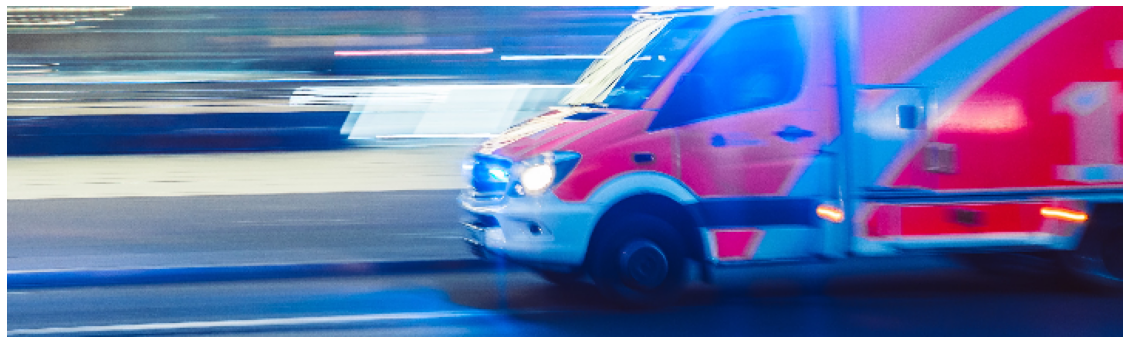

In [13]:
colors = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing_with_Disaster_Tweets/Dataset/nlp1-cover.jpeg"))
colors = colors[::5,::5]
mask = colors.copy()
mask[mask.sum(axis = 2) == 0] = 255
width = colors.shape[1]
height = colors.shape[0]
plt.figure(figsize = (20, 40))
plt.axis('off')
plt.imshow(colors)
plt.show()

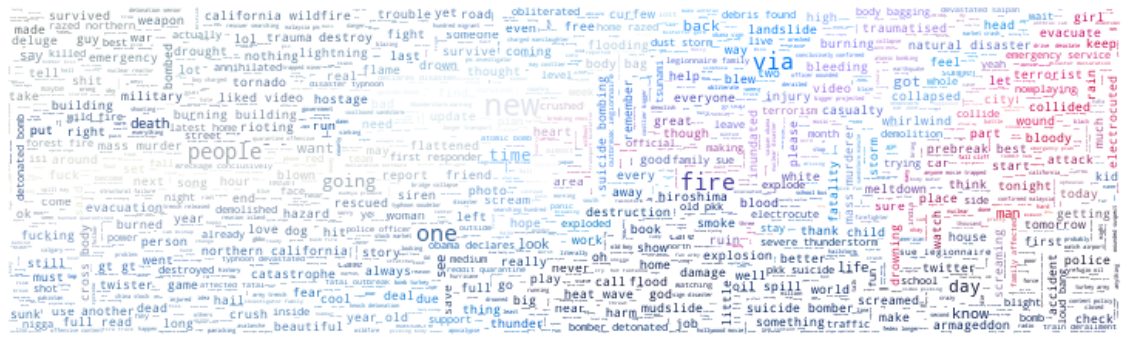

In [14]:
wc=WordCloud(
    max_words = 3000, 
    relative_scaling = 1,
    max_font_size = 20,
    min_font_size = 2,
    width = width, height = height,
    background_color = "white",
    mask = mask
).generate(" ".join(tr))
image_colors = ImageColorGenerator(colors)
wc.recolor(color_func = image_colors)
plt.figure(figsize=(20, 40))
plt.axis('off')
plt.imshow(wc, interpolation = "bilinear")
plt.show()

<p style="font-size : 16px">The following word cloud is divided into fake news and real news. The larger the word, the more often it appears.</p>

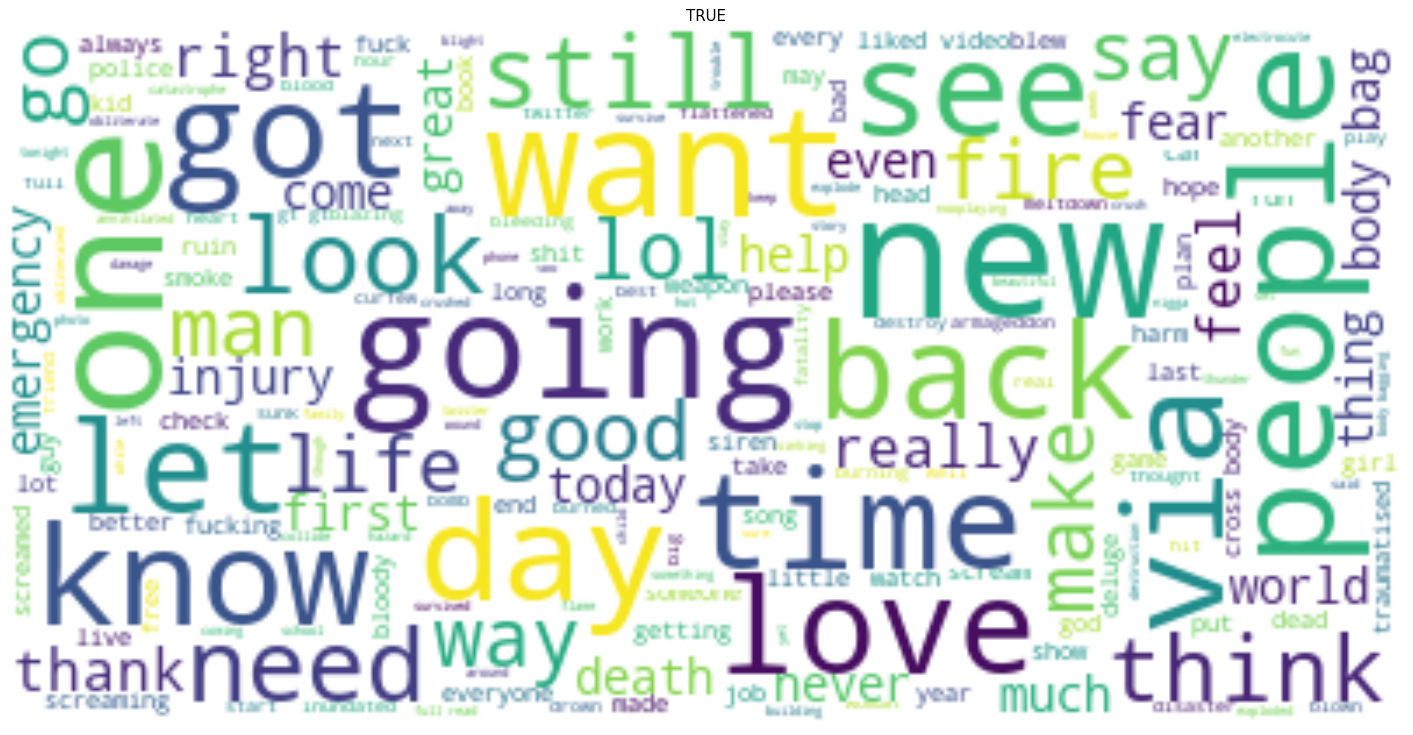

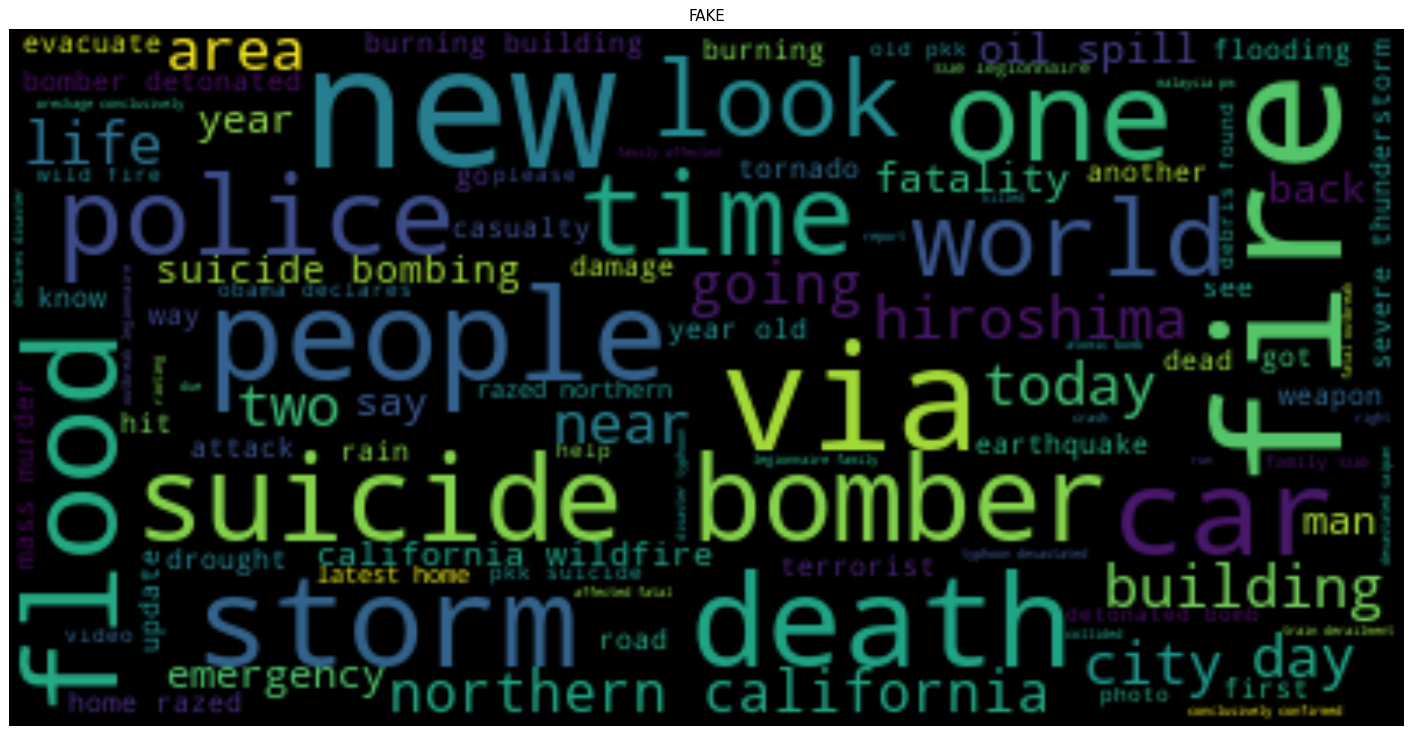

In [15]:
for C, W in {"white": T, "black": F}.items():
    wc=WordCloud(
        background_color=C, 
        max_font_size=50,
        max_words=2000,
        width=400, height=200
    ).generate(" ".join(W))
    plt.figure(figsize=(20,40), dpi=90)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title('TRUE' if C == "white" else "FAKE")
    plt.show()

><p style="font-size : 16px">As can be clearly seen, the words in the real news tend to be positive and those in the fake news tend to be negative. However, there are also words that appear frequently in both, such as "new" or "time. This shows that a simple classification with words, without considering the context, would lead to a questionable classification.</p>

In [16]:
np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2])
te_val, _, _ = cleaner(train.loc[r <= 0.2], labeled=False)

<font size="+1" color="grey"><b>1.3 Text Mining with Frequency Plot </b></font><br><a id="1.3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Which words are most often found in the test data set but not in the training data set and vice versa. The words that occur exclusively in the training data set do not seem to be so important for the later classification. The words that occur only in the test dataset cannot be used directly in the learning hypothesis.</p>

In [17]:
just_real = [w for w in T if w not in F]
just_fake = [w for w in F if w not in T]

In [18]:
Just_Real = nltk.probability.FreqDist()
Just_Fake = nltk.probability.FreqDist()

for w in just_real:
    Just_Real[w] += 1

for w in just_fake:
    Just_Fake[w] += 1

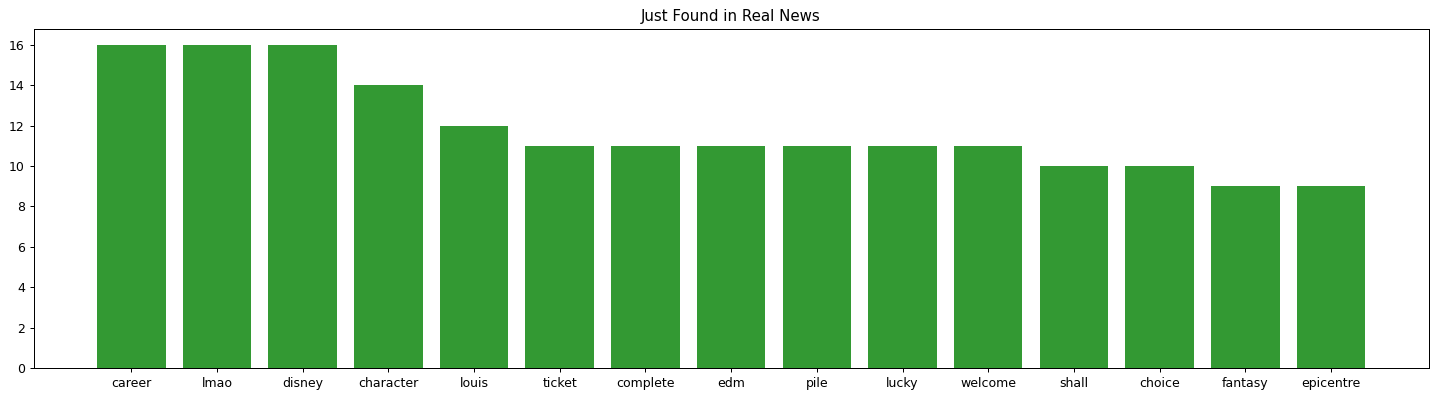

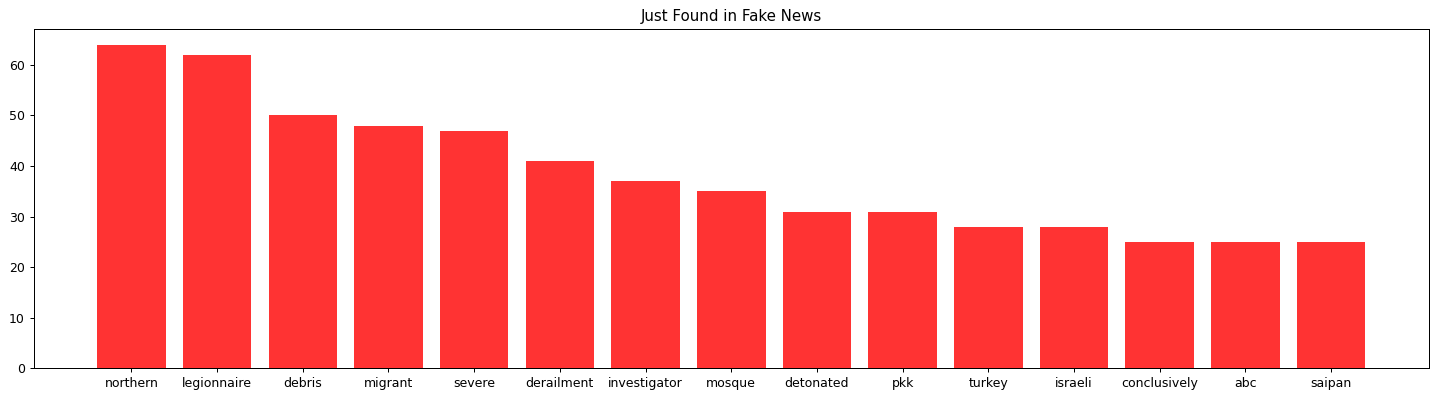

In [19]:
for C, W in {"green": Just_Real, "red": Just_Fake}.items():
    Frequency = pd.DataFrame({"Words": list(W.keys()),"Frequency": list(W.values())})
    Frequency = Frequency.sort_values("Frequency", ascending=False).iloc[:15]
    plt.figure(figsize=(20, 5), dpi=90)
    if C == "green":
        plt.title("Just Found in Real News")
    else:
        plt.title("Just Found in Fake News")
    plt.bar(Frequency.Words, Frequency.Frequency, color=C, alpha=0.8)

<font size="+1" color="grey"><b>1.4 Prepare Text for ML </b></font><br><a id="1.4"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">So let's see what possibilities there are in the field of text classification. Since it is a binary classification, one could theoretically use all classification methods. That would be for example:</p>

* Logistic or Probabilistic Regression
* K-nearest neighbors
* Decision tree methods
* Support Vector Machines
* Neural Networks

<p style="font-size : 16px">The simplest method in the NLP field are N-grams. 
<p style="font-size : 16px">We start by looking up N-Grams. However, Neural Networks produce the best results for homogeneous data, such as images or natural language. Therefore, after the N-Grams we focus on deep learning methods.</p>

<font size="+1" color="grey"><b>1.4.1 N-Grams </b></font><br><a id="1.4.1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Here we look at the frequency of certain word combinations in the context of each other. </p>
<p style="font-size : 16px">Let's look at the sentence "I am a Data Scientist". If we use a 2-Gram, then the sentence would be transformed into:</p>
<p style="font-size : 16px">"I am", "am a", "a Data", "Data Scientist".</p>
<p style="font-size : 16px">analogously, there would also be 3-Grams:</p>
<p style="font-size : 16px">"I am a", "am a Data", "a Data Scientist".</p>
<p style="font-size : 16px">Now we look how often the same word combinations occur in the whole text.</p>
<p style="font-size : 16px">Assuming "I am a" would occur 10x and the word am would occur 20x, then 10/20 would be calculated to get a kind of probability for the word combination "I am a" around the word "am".</p>


In [20]:
np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2])
te_val, _, _ = cleaner(train.loc[r <= 0.2], labeled=False)

before = [i for i in tr_val if tr_val.index(i) in [0,2]]

In [21]:
vectorizer = TfidfVectorizer(
    min_df= 2, 
    max_df = 0.2, 
    analyzer = 'char_wb', 
    ngram_range = (3,7)
)
vectorizer.fit(tr_val + te_val)
tr=vectorizer.transform(tr_val)
te=vectorizer.transform(te_val)

In [22]:
model = R(
    alpha=0.2
)

In [23]:
model.fit(tr, y_tr_val)

Ridge(alpha=0.2)

In [24]:
Predictions = model.predict(te)
Predictions = np.where(Predictions >= 0.8, 1, 0)

In [25]:
print("Accuracy using N-Grams is:", np.round(acu(Predictions, y_te_val)*100, 2), "%")

Accuracy using N-Grams is: 74.31 %


<font size="+1" color="grey"><b>1.4.2 Tokenization </b></font><br><a id="1.4.2"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [26]:
np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

before = [i for i in tr_val if tr_val.index(i) in [0,2]]

<p style="font-size : 16px">A text to sequence tokenizer is a procedure in which a unique value (number) is assigned to each word. A maximum number of words is defined so as not to have too many categories. It is very important that the tokenizer is used for both training and test data sets. If a separate tokenizer were created for each record, different words would be assigned to different categories. Tokenization is a fundamentally critical procedure. As shown above, there are often words in the test but not in the training data set and vice versa. This problem can be counteracted by different procedures. More about this later.</p>

In [27]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr_val)
tr_val = tokenizer.texts_to_sequences(tr_val)
te_val = tokenizer.texts_to_sequences(te_val)

vocabulary_size_val = len(tokenizer.index_word)+1

after = [i for i in tr_val if tr_val.index(i) in [0,2]]

print("Before: \n" + str(before) + "\n\n" + "After: \n" + str(after))

Before: 
['our deeds are the reason of this earthquake may allah forgive us all', 'people receive wildfires evacuation orders in california']

After: 
[[106, 3639, 16, 1, 698, 6, 21, 340, 133, 1549, 5384, 72, 40], [52, 3640, 1399, 205, 1290, 4, 86]]


<p style="font-size : 16px">The last word from the first sentence and the first word from the last sentence are the same. therefore both get the same token (id).</p>

<font size="+1" color="grey"><b>1.4.3 Padding </b></font><br><a id="1.4.3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">If you think of the individual sentences whose words have been cleaned and converted into numbers (tokens) as a data set in a tabular form, then it becomes clear that the longest sentence represents the width of the table and the number of sentences represents the length of the data set. Thus, to create such a form, all records must first be made equal in length. To do this, the tokens missing up to the length of the longest record are simply filled with zeros. This procedure is called padding. There are several types of padding. For example, the zeros can be filled at the end (post-padding) or at the beginning (pre-padding). Centering is also conceivable. We decide here for a post padding. It is important to say that it is not necessary to expand to the longest sentence. If, for example, there is a very long sentence with e.g. 200 words and the second longest sentence is just 20 words, then a lot of information will be lost later during learning due to the huge number of meaningless zeros. So much in advance, this is the problem BERT is dealing with.</p>

낱말을 정리하고 숫자(토큰)로 변환한 개별 문장을 표 형식의 데이터 집합으로 생각하면, 가장 긴 문장은 표의 너비를, 문장 수는 데이터 집합의 길이를 나타내는 것이 분명해진다. 그러므로, 그러한 형태를 만들기 위해서는, 모든 기록들이 먼저 길이가 같아져야 한다. 이를 위해 가장 긴 레코드의 길이까지 누락된 토큰은 단순히 0으로 채워집니다. 이 절차를 패딩이라고 합니다. 패딩에는 여러 종류가 있습니다. 예를 들어, 0은 끝(포스트 패딩) 또는 시작(사전 패딩)에서 채울 수 있습니다. 센터링도 생각할 수 있습니다. 우리는 여기서 포스트 패딩을 결정해요. 굳이 가장 긴 문장으로 확대할 필요는 없다는 것이 중요하다. 예를 들어, 200개의 단어로 된 매우 긴 문장이 있고 두 번째로 긴 문장이 20개의 단어에 불과하다면, 의미 없는 0개의 엄청난 숫자 때문에 나중에 학습하는 동안 많은 정보가 손실될 것이다. 이것은 BERT가 다루고 있는 문제입니다.

In [28]:
length_val=max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

In [29]:
tr_val = pad_sequences(tr_val, padding='post', maxlen=length_val)
te_val = pad_sequences(te_val, padding='post', maxlen=length_val)

print("After Padding to a length of: " + str(length_val) + "\n\n" + str(tr_val[[0,2]]))

After Padding to a length of: 32

[[ 106 3639   16    1  698    6   21  340  133 1549 5384   72   40    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  52 3640 1399  205 1290    4   86    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


<font size="+3" color="grey"><b>2. LSTM </b></font><br><a id="2"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">An Long Short Term Memory (LSTM) is A Neural Network. The difference to a normal neural network is that loops are built in, which act like a memory, similar to exponential smoothing. Thereby not only each observation leads directly to an output, but is stored weighted by the loop in the neural network. The LSTM differs additionally by the so-called cell state. This represents a long-term memory, which first forgets a part by multiplication with the previous cell state and then, if necessary, multiplies another, newer part to the memory. This means that there is not only a short-term memory through the loop, but also a long-term memory - hence the name LSTM. Since language is often very complex and not every sentence unfolds its meaning from left to right, a bidirectional LSTM is used.</p>

<img height="700" width="700" src="https://www.researchgate.net/profile/Juan_Victores/publication/334360853/figure/fig1/AS:778955447599106@1562728859405/The-LSTM-cell-internals.png">

<p style="font-size : 12px"><em>Image from: <a href="https://www.researchgate.net/profile/Juan_Victores/publication/334360853/figure/fig1/AS:778955447599106@1562728859405/The-LSTM-cell-internals.png">here</a></em></p>

<font size="+1" color="grey"><b>2.1 Embeddings </b></font><br><a id="2.1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Instead of one hot encoding, which often leads to high variance, we use word embeddings. The one-hot matrix is used as input to match the weightings of the hidden layers with the individual categories. Depending on how many hidden layers are used so many features are created by the embedding. An embedding is therefore a preliminary neural network for categorical feature encoding.</p>

<p style="font-size : 16px">input_dim is the number of categories to encode.
output_dim is the number of hidden layers (features) you want to obtain. The lower the output_dim, the more information is lost. However, this is accompanied by a reduction in complexity, which reduces the predictive variance.</p>

In [30]:
def BiDirLSTM(vocSize, inpShape, seeds = seed):
    np.random.seed(seeds)
    set_seed(seeds)
    inp = Input(shape = (inpShape), name = "input")
    emb = Embedding(
        input_dim = vocSize,
        output_dim = 4
    )(inp)
    drop = Dropout(0.3)(emb)
    biLstm = Bidirectional(
        LSTM(
            units=16,
            activation='tanh',
            return_sequences = True,
            stateful=False,
            recurrent_dropout = 0.4,
            dropout=0.4
        )
    )(drop)
    biLstm = Bidirectional(
        LSTM(
            units = 8,
            activation ='tanh',
            return_sequences = False,
            stateful = False,
            recurrent_dropout = 0.3,
            dropout = 0.3
        )
    )(biLstm)

    out = Dense(units = 1, activation = "sigmoid")(biLstm)

    m = Model(inputs = inp, outputs = out)
    m.summary()
    return m

In [31]:
model = BiDirLSTM(vocabulary_size_val, length_val)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 4)             48916     
                                                                 
 dropout (Dropout)           (None, 32, 4)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 32, 32)           2688      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 17    

In [32]:
optimizer = Adamax(
    lr=0.01, 
    decay=0.0005, 
    clipvalue=10
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [33]:
loss = BinaryCrossentropy(label_smoothing=0.01)

In [34]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)

<font size="+1" color="grey"><b>2.2 The Results of a Simple LSTM </b></font><br><a id="2.2"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [35]:
history = model.fit(
    x = tr_val, 
    y = y_tr_val,
    validation_data = (te_val, y_te_val),
    epochs = 10,
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

Epoch 1/10
64/64 [==============================] - 47s 570ms/step - loss: 0.6389 - accuracy: 0.6335 - val_loss: 0.5577 - val_accuracy: 0.7121
Epoch 2/10
64/64 [==============================] - 37s 572ms/step - loss: 0.5117 - accuracy: 0.7610 - val_loss: 0.4962 - val_accuracy: 0.7721
Epoch 3/10
64/64 [==============================] - 38s 590ms/step - loss: 0.4514 - accuracy: 0.8026 - val_loss: 0.4684 - val_accuracy: 0.7866
Epoch 4/10
64/64 [==============================] - 36s 561ms/step - loss: 0.4206 - accuracy: 0.8195 - val_loss: 0.4913 - val_accuracy: 0.7938
Epoch 5/10
64/64 [==============================] - 37s 578ms/step - loss: 0.3806 - accuracy: 0.8430 - val_loss: 0.4743 - val_accuracy: 0.8004
Epoch 6/10
64/64 [==============================] - 37s 585ms/step - loss: 0.3543 - accuracy: 0.8559 - val_loss: 0.4833 - val_accuracy: 0.7826
Epoch 7/10
64/64 [==============================] - 37s 573ms/step - loss: 0.3383 - accuracy: 0.8650 - val_loss: 0.4889 - val_accuracy: 0.8004

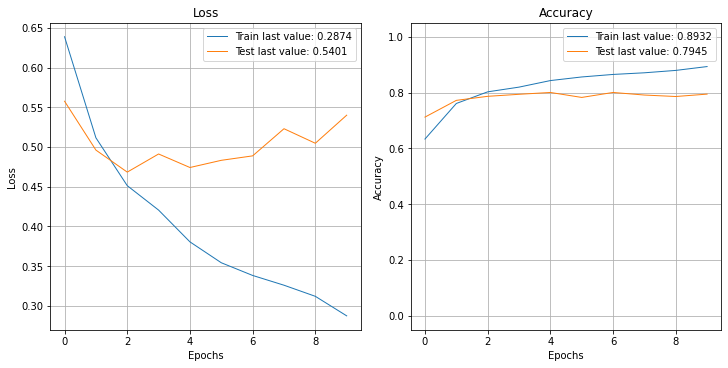

In [36]:
plot_history(history)
plt.show()

<p style="font-size : 16px">As can be seen, the results are already quite acceptable, but also somewhat unstable, which can be seen in the loss.</p>

<font size="+1" color="grey"><b>2.3 Submission Simple LSTM</b></font><br><a id="2.3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [37]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, _, _ = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

In [38]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr)
tr = tokenizer.texts_to_sequences(tr)
te = tokenizer.texts_to_sequences(te)

vocabulary_size = len(tokenizer.index_word)+1

In [39]:
length=max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [40]:
tr = pad_sequences(tr, padding='post', maxlen=length)
te = pad_sequences(te, padding='post', maxlen=length)

In [41]:
model = BiDirLSTM(vocabulary_size, length)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 32, 4)             55540     
                                                                 
 dropout_1 (Dropout)         (None, 32, 4)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 32, 32)           2688      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 17  

In [42]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)

In [43]:
history = model.fit(
    x=tr, 
    y=y,
    epochs = 10,
    batch_size = 96, 
    shuffle = True,
    verbose=0
)

In [44]:
Predictions = model.predict(
    x=te
)

<p style="font-size : 16px">Let's look at the predicted probabilities.<p/>

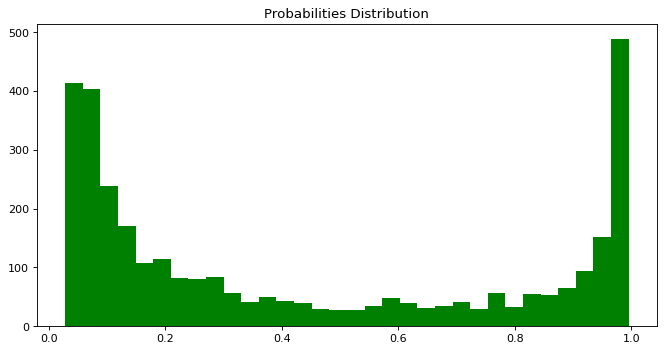

In [45]:
baseline = Predictions
plt.figure(figsize = (10,5), dpi = 80)
plt.hist(
    baseline, 
    bins = 32, 
    color = 'g',
    label = 'baseline'
)

plt.title('Probabilities Distribution')
plt.show()

In [46]:
subm = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing_with_Disaster_Tweets/Dataset/sample_submission.csv")

In [47]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0


In [48]:
subm.to_csv("Submission_Basic.csv", index=False)

In [49]:
# colors=np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing_with_Disaster_Tweets/Dataset/__results___110_0.png"))
# width=colors.shape[1]
# height=colors.shape[0]
# plt.figure(figsize=(2, 3))
# plt.axis('off')
# plt.imshow(colors)
# plt.show()

<font size="+3" color="grey"><b>3. Word2Vec with GenSim </b></font><br><a id="3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">As mentioned above, tokenization must always be "trained" on the training data set. This means that the test data set contains words that cannot be assigned by the algorithm. If one continues the consideration, then one finds out that a similar problem is also present in the training data set itself. Since words can also be replaced by synonyms, but synonyms do not always say exactly the same thing, it would make sense to describe the individual words by their similarity to each other instead of a simple tokenization that just assigns a value to each word. This would have the advantage that similar words would also be interpreted similarly. This is the idea behind Unsupervised Learning approaches. Here a kind of autoencoder is trained, which takes up the individual words by embeddings, reduces these in their dimensionality e.g. to 200 and then restores again. The resulting embeddings yield 200 dimensions for each word, which represent the context of the word in the respective introduced text. Now only each word in the text must be replaced by these e.g. 200 dimensions. You can imagine that this will be a big computational effort. But it is worth it. Studies show that the performance of the algorithms can be increased significantly.</p>

<img height="800" width="800" src="https://cdn-images-1.medium.com/max/1600/1*SFuHVAWXWB914rSGAZYLzA.png">
<p style="font-size : 12px"><em>Image from: <a href="https://towardsdatascience.com/word2vec-made-easy-139a31a4b8ae">here</a></em></p>

<p style="font-size : 16px">There are two different architectures. Continuous bag-of-words (CBOW) or continuous skip-gram. In the continuous bag-of-words architecture, the model predicts the current word from a window of surrounding context words wherehe the order of context words does not influence prediction. In the continuous skip-gram architecture, the model uses the current word to predict the surrounding window of words. The skip-gram architecture gives nearby context words a higher weight than more distant context words. The following is an example of the sentence "the quick brown fox jumps over the lazy dog" with a window size of two.</p>

<img height="700" width="700" src="https://cdn-images-1.medium.com/max/1600/1*yiH5sZI-IBxDSQMKhvbcHw.png">
<p style="font-size : 12px"><em>Image from: <a href="https://medium.com/ml2vec/using-word2vec-to-analyze-reddit-comments-28945d8cee57">here</a></em></p>

<p style="font-size : 16px">But there is also a less computationally intensive variant that increases performance. Word2Vec also makes it possible to find synonyms that match the context of the text. These can be applied to the test and validation data set and then lead to fewer unknown words being found in it. Here we will use both variants</p>

In [50]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, o, o = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

<font size="+1" color="grey"><b>3.1 Word2Vec</b></font><br><a id="3.1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">  </p>

In [51]:
emb = [s.split(" ") for s in tr]
emb.extend([s.split(" ") for s in te])

<p style="font-size : 16px">A good tuning of the parameters is important. This can be easily checked by synonyms. If the synonyms make sense in context, then the tuning probably worked.</p>

* We use all words (train and test) for the training
* min_count is the minimum number of words for which the methods should be applied
* window is the windowsize.
* sg = 1 means use skip gram sg =  means use CBOW.

<p style="font-size : 16px">A good tuning of the parameters is important. This can be easily checked by synonyms. If the synonyms make sense in context, then the tuning probably worked. Below, we check whether the most likely synonyms (this must always be considered in the context of the data set) make sense.<p>

In [52]:
w2v =  gensim.models.Word2Vec(
    emb, 
    min_count=4,
    workers=4, 
    window =5, 
    sg = 1
)

words=["fire", "flood", "died", "accident", "closed", "help", "twitter", "air", "everything"]

for w in words:
    print(w + " is " + w2v.wv.most_similar(w, topn=1)[0][0])

fire is buildings
flood is combo
died is young
accident is airplane
closed is brush
help is destroy
twitter is fine
air is helicopter
everything is alone


<p style="font-size : 16px">At least from the feeling the synonyms fit into the context of the text. Now we replace the words that do not occur in the training data set but do occur in the test data set with the most likely synonyms.</p>

In [53]:
!pip show gensim

Name: gensim
Version: 4.2.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: /usr/local/lib/python3.7/dist-packages
Requires: smart-open, scipy, numpy
Required-by: 


In [54]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
def wordChanger(trainList, testList, minSimilar=0.5, numPrint=300):

    te_listList = [s.split(" ") for s in testList]

    tr_uniques=set(" ".join(trainList).split(" "))
    wc = 0
    try:
        for i, s in enumerate(te_listList):
            for j, w in enumerate(s):
                if w not in tr_uniques and w in w2v.wv.index_to_key and w2v.wv.most_similar(w, topn=1)[0][0] in tr_uniques \
                and w2v.wv.most_similar(w, topn=1)[0][1] >= minSimilar:
                    te_listList[i][j] = w2v.wv.most_similar(w, topn=1)[0][0]
                    wc += 1
                    if i < numPrint:
                        print(w + " changed in " + w2v.wv.most_similar(w, topn = 1)[0][0])

    except Error as e:
        print(w + " Err: " + e)

    print(str(wc) + " words changed")
    
    te_listList = [" ".join(s) for s in te_listList]
    
    return te_listList

In [56]:
te_val = wordChanger(tr_val, te_val)

kiss changed in ear
coahuila changed in swiss
coahuila changed in swiss
esp changed in losing
salvation changed in member
salvation changed in member
preseason changed in ems
esp changed in losing
keeping changed in lesbian
higher changed in hearing
higher changed in hearing
46 words changed


<font size="+1" color="grey"><b>3.2 LSTM with Context Synonyms</b></font><br><a id="3.2"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px"> Now we use the same model again, only with the difference that now more words should be known in the validation data set. </p>

In [57]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr_val)
tr_val = tokenizer.texts_to_sequences(tr_val)
te_val = tokenizer.texts_to_sequences(te_val)

vocabulary_size_val = len(tokenizer.index_word)+1

In [58]:
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

In [59]:
tr_val = pad_sequences(tr_val, padding='post', maxlen=length_val)
te_val = pad_sequences(te_val, padding='post', maxlen=length_val)

In [60]:
model = BiDirLSTM(vocabulary_size_val, length_val)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 32, 4)             48916     
                                                                 
 dropout_2 (Dropout)         (None, 32, 4)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 32, 32)           2688      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 17  

In [61]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)

In [62]:
history = model.fit(
    x = tr_val, 
    y = y_tr_val,
    validation_data = (te_val, y_te_val),
    epochs = 10, 
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

Epoch 1/10
64/64 [==============================] - 65s 764ms/step - loss: 0.6795 - accuracy: 0.5706 - val_loss: 0.6587 - val_accuracy: 0.5586
Epoch 2/10
64/64 [==============================] - 36s 565ms/step - loss: 0.5719 - accuracy: 0.7129 - val_loss: 0.5238 - val_accuracy: 0.7589
Epoch 3/10
64/64 [==============================] - 36s 556ms/step - loss: 0.5007 - accuracy: 0.7675 - val_loss: 0.4906 - val_accuracy: 0.7740
Epoch 4/10
64/64 [==============================] - 34s 538ms/step - loss: 0.4596 - accuracy: 0.7985 - val_loss: 0.4815 - val_accuracy: 0.7846
Epoch 5/10
64/64 [==============================] - 34s 531ms/step - loss: 0.4184 - accuracy: 0.8197 - val_loss: 0.4777 - val_accuracy: 0.7931
Epoch 6/10
64/64 [==============================] - 37s 576ms/step - loss: 0.3953 - accuracy: 0.8371 - val_loss: 0.4685 - val_accuracy: 0.7879
Epoch 7/10
64/64 [==============================] - 34s 533ms/step - loss: 0.3805 - accuracy: 0.8428 - val_loss: 0.4901 - val_accuracy: 0.7925

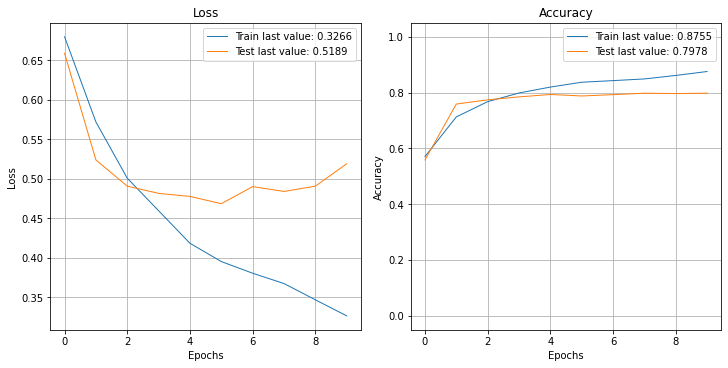

In [63]:
plot_history(history)
plt.show()

<p style="font-size : 16px">It is noticeable that even by adjusting so few words in the validation dataset, an improvement of the stability of the model occurred - which is not surprising, since more words were known in context. </p>

<font size="+1" color="grey"><b>3.3 Submission Word2Vec Context Synonyms</b></font><br><a id="3.3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [64]:
te = wordChanger(tr, te)

gresham changed in billings
gresham changed in billings
smith changed in skills
39 words changed


In [65]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr)
tr = tokenizer.texts_to_sequences(tr)
te = tokenizer.texts_to_sequences(te)

vocabulary_size = len(tokenizer.index_word)+1

In [66]:
length=max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [67]:
tr = pad_sequences(tr, padding='post', maxlen=length)
te = pad_sequences(te, padding='post', maxlen=length)

In [68]:
model = BiDirLSTM(vocabulary_size, length)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 32, 4)             55540     
                                                                 
 dropout_3 (Dropout)         (None, 32, 4)             0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 32, 32)           2688      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 17  

In [69]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics=["accuracy"]
)

In [70]:
history = model.fit(
    x = tr, 
    y = y,
    epochs = 10, 
    batch_size = 96, 
    shuffle = True,
    verbose =0
)

In [71]:
Predictions = model.predict(
    x=te
)

<p style="font-size : 16px">Compare the distribution of the predictions with the baseline:</p>

In [72]:
def comHist(base, pred, lab :str):
    plt.figure(figsize=(10,5), dpi= 80)
    plt.hist(
        base, 
        bins=32, 
        alpha=1, 
        color='g',
        label='baseline', 
    )

    plt.hist(
        pred, 
        bins=32, 
        alpha=0.5, 
        color='r',
        label=lab,
        linestyle='dashed',
        edgecolor = 'w'
    )
    plt.legend(loc='upper right')
    plt.title('Probabilities Distribution')
    plt.show()

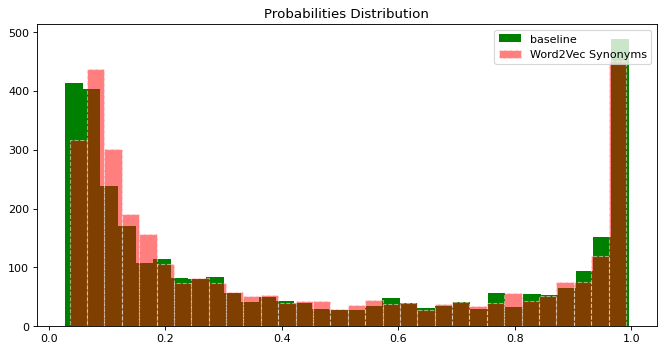

In [73]:
comHist(baseline, Predictions, "Word2Vec Synonyms")

<p style="font-size : 16px">Large differences are mainly found in the extreme values zero and one.</p>

In [74]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0


In [75]:
subm.to_csv("Submission_W2V.csv", index=False)

In [76]:
# colors=np.array(Image.open("../input/imagesforkernels/w2v-subm.JPG"))
# width=colors.shape[1]
# height=colors.shape[0]
# plt.figure(figsize=(2, 3))
# plt.axis('off')
# plt.imshow(colors)
# plt.show()

FileNotFoundError: ignored

<font size="+1" color="grey"><b>3.4 Glove Embeddings with GenSim</b></font><br><a id="3.4"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [77]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, o, o = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, o, o = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, o, o = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

<p style="font-size : 16px">GenSim has a downloader that can be used to load pre-trained models. There is a pretrained vector from Twitter (glove twitter 25) generated from tweets. The 25 stands for the number of dimensions </p>

In [78]:
glove = api.load("glove-twitter-25")

for w in words:
    print(w + " is " + glove.most_similar(w, topn=1)[0][0])

[==================================================] 100.0% 104.8/104.8MB downloaded
fire is run
flood is closure
died is killed
accident is crash
closed is flight
help is save
twitter is facebook
air is jet
everything is something


<p style="font-size : 16px"> To limit the computational effort, we reduce the size of the embeddings from 100 to vecSize. To be able to display all words, it is also necessary to set the minimum size to 1.</p>

In [79]:
vecSize = 25
w2v = gensim.models.Word2Vec(
    emb, 
    vector_size = vecSize,
    min_count = 1,
    workers = 4, 
    window = 6, 
    sg = 1
)

for w in words:
    print(w + " is " + w2v.wv.most_similar(w, topn=1)[0][0])

fire is buildings
flood is combo
died is bringing
accident is airplane
closed is began
help is destroy
twitter is dude
air is helicopter
everything is eat


<p style="font-size : 16px"> Looks still pretty good. Now we use the predtraines glove vector if the word is available, else we use our own w2v. </p>

In [80]:
def gloveEmbedder(df_tr, df_te):
    etr = []
    ete = []

    for s in df_tr:
        s = [glove[f"{w}"] if w in glove.index_to_key else w2v.wv[f"{w}"] for w in s.split()]
        s = list(np.ravel(s))
        etr.append(s)

    for s in df_te:
        s = [glove[f"{w}"] if w in glove.index_to_key else w2v.wv[f"{w}"] for w in s.split()]
        s = list(np.ravel(s))
        ete.append(s)

    l=max([max([len(i) for i in etr]), max([len(i) for i in ete])])

    print("Each sentence will have a lengt of " + str(l))
    return etr, ete, l

In [81]:
emb_tr_val, emb_te_val, length_val = gloveEmbedder(tr_val, te_val)

Each sentence will have a lengt of 800


<p style="font-size : 16px"> It is important to change the data type to a float datatyp.</p>

In [82]:
emb_tr_val = pad_sequences(emb_tr_val, padding='post', maxlen=length_val, dtype='float32')
emb_te_val = pad_sequences(emb_te_val, padding='post', maxlen=length_val, dtype='float32')

<p style="font-size : 16px"> Reshaping for LSTM. Since we already have the embeddings, we will apply the LSTM without embeddings. Therefore, the shape of the dataset must be divided into (samples, timesteps, features). We have a 20 dimensional embedding. Each set will be a sample with 680 timesteps and 20 features.</p>

In [83]:
timesteps=int(length_val/vecSize)
emb_tr_val = emb_tr_val.reshape(-1, timesteps, vecSize)
emb_te_val = emb_te_val.reshape(-1, timesteps, vecSize)
shape = emb_tr_val.shape[1:]

In [84]:
def BiDirLSTM(inpShape, seeds = seed):
    np.random.seed(seeds)
    set_seed(seeds)
    
    inp = Input(shape = (inpShape), name = "input")
    drop = Dropout(0.4)(inp)
    biLstm = Bidirectional(
        LSTM(
            units =192,
            activation ='tanh',
            return_sequences = True,
            stateful = False,
            recurrent_dropout = 0.4,
            dropout = 0.4
        )
    )(drop)
    biLstm = Bidirectional(
        LSTM(
            units = 8,
            activation = 'tanh',
            return_sequences = False,
            stateful = False,
            recurrent_dropout = 0.4,
            dropout = 0.3
        )
    )(biLstm)

    out = Dense(units = 1, activation = "sigmoid")(biLstm)

    m = Model(inputs = inp, outputs = out)
    m.summary()
    return m

In [85]:
model = BiDirLSTM(inpShape = shape)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 25)]          0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 25)            0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 32, 384)          334848    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 16)               25152     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 360,017
Trainable params: 360,017
Non-trainab

In [86]:
optimizer = Adamax(
    lr = 0.015, 
    decay = 0.0002, 
    clipvalue = 10
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [87]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)

In [88]:
history = model.fit(
    x = emb_tr_val, 
    y = y_tr_val,
    validation_data = (emb_te_val, y_te_val),
    epochs = 15, 
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

Epoch 1/15
64/64 [==============================] - 41s 510ms/step - loss: 0.5575 - accuracy: 0.7252 - val_loss: 0.4994 - val_accuracy: 0.7819
Epoch 2/15
64/64 [==============================] - 33s 518ms/step - loss: 0.5183 - accuracy: 0.7537 - val_loss: 0.4821 - val_accuracy: 0.7912
Epoch 3/15
64/64 [==============================] - 32s 502ms/step - loss: 0.5013 - accuracy: 0.7636 - val_loss: 0.5306 - val_accuracy: 0.7543
Epoch 4/15
64/64 [==============================] - 32s 493ms/step - loss: 0.5082 - accuracy: 0.7628 - val_loss: 0.4785 - val_accuracy: 0.7819
Epoch 5/15
64/64 [==============================] - 31s 491ms/step - loss: 0.5021 - accuracy: 0.7670 - val_loss: 0.4664 - val_accuracy: 0.7931
Epoch 6/15
64/64 [==============================] - 33s 523ms/step - loss: 0.4929 - accuracy: 0.7642 - val_loss: 0.5005 - val_accuracy: 0.7615
Epoch 7/15
64/64 [==============================] - 32s 497ms/step - loss: 0.4854 - accuracy: 0.7742 - val_loss: 0.4736 - val_accuracy: 0.7866

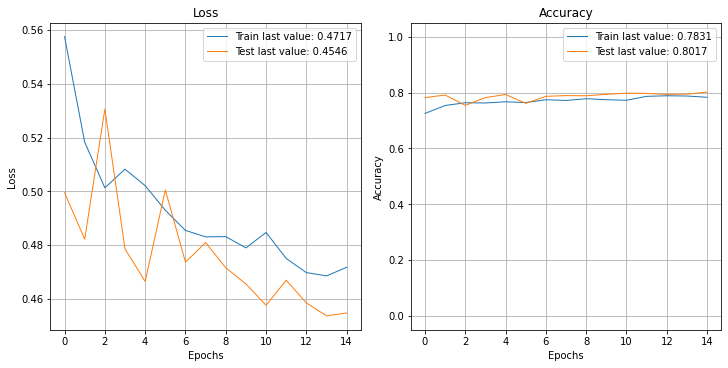

In [89]:
plot_history(history)
plt.show()

<p style="font-size : 16px">  The loss of the model has improved significantly, while the accuracy is similar to the previous models. The biggest difference is that the model converges much better. </p>

<font size="+1" color="grey"><b>3.5 Submission Glove Embeddings</b></font><br><a id="3.5"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [90]:
emb_tr, emb_te, length = gloveEmbedder(tr, te)

Each sentence will have a lengt of 825


In [91]:
emb_tr = pad_sequences(emb_tr, padding='post', maxlen=length, dtype='float32')
emb_te = pad_sequences(emb_te, padding='post', maxlen=length, dtype='float32')

In [92]:
timesteps = int(length/vecSize)
emb_tr = emb_tr.reshape(-1, timesteps, vecSize)
emb_te = emb_te.reshape(-1, timesteps, vecSize)
shape = emb_tr.shape[1:]

In [93]:
model = BiDirLSTM(inpShape=shape)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 33, 25)]          0         
                                                                 
 dropout_5 (Dropout)         (None, 33, 25)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 33, 384)          334848    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 16)               25152     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 360,017
Trainable params: 360,017
Non-trainab

In [94]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics=["accuracy"]
)

In [95]:
history = model.fit(
    x = emb_tr, 
    y = y,
    epochs = 15, 
    batch_size = 96, 
    shuffle = True,
    verbose = 0
)

In [96]:
Predictions = model.predict(
    x = emb_te
)

<p style="font-size : 16px">Compare the distribution of the predictions with the baseline:</p>

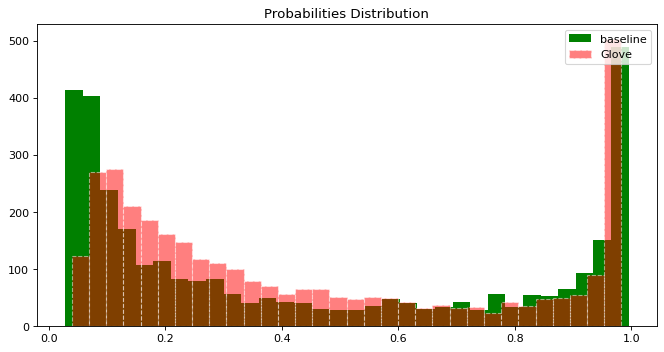

In [97]:
comHist(baseline, Predictions, "Glove")

In [98]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0


In [99]:
subm.to_csv("Submission_W2V_Embed.csv", index = False)

In [100]:
colors = np.array(Image.open("../input/imagesforkernels/emb-subm.JPG"))
width = colors.shape[1]
height = colors.shape[0]
plt.figure(figsize = (2, 3))
plt.axis('off')
plt.imshow(colors)
plt.show()

FileNotFoundError: ignored

<font size="+3" color="grey"><b>4. BERT </b></font><br><a id="4"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px"> BERT is actually just a special architecture. The special thing here is in the detail - especially in the so-called Self Attention. </p>

<font size="+1" color="grey"><b>4.1 Attention </b></font><br><a id="4.1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Attention gives humans the ability to focus on what is important. That is, a human always solves a problem contextually, which machines until 2015 Bahdanau et al proposed the first attention model. If you ask a human which is the main character of a story, he will remember the most important, most frequently occurring person. This mechanism is called attention. Attention comes from automatic translations in the field of Deep Learning. Especially for very long sentences, classic approaches with Reccurente Neural Networks fail because they use an encoder to compress a sentence (fixed context vector) and then a decoder to translate it into another language word by word. The context vector which is the last hidden state of the RNN compresses the information before a context is set. This is called the long-range dependency problem.</p>

<p style="font-size : 16px">The idea behind attention is now to give decoder more information instead of just using the last hidden state.  </p>

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/Screenshot-2019-11-19-at-2.16.39-PM.png)

<p style="font-size : 12px"><em>Table from: <a href="https://arxiv.org/abs/1409.0473">here</a></em></p> 

<p style="font-size : 16px">The Bidirectional LSTM generates a sequence of annotations (h1, h2,….., hT) for each available sentence. Now, the context vector for the output word "y" is calculated using the weighted sum of annotations. So we achieve attention between the input and output sequences.</p>

<font size="+1" color="grey"><b>4.2 Transformer </b></font><br><a id="4.2"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Now that we know what attention means between encoder and decoder, we deal with another kind of attention, self attention. The self-attention model allows inputs to interact with other inputs to focus on the most important information. The special feature is that RNNs are completely avoided. In self attention, each word is compared to each other within a sentence to determine similarities. This is done over several layers. The result is that it is not where a word is placed that matters, but what relationship it has to others to determine what information is truly essential. This does not mean that the position of the word does not matter, quite the opposite. However, the meaning of the word should be as far as possible free from the position in the sentence. The procedure allows the decoder to match words based on context - not a fixed context vector.</p>

<img height="500" width="500" src="https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/img/MultiHead.png">
<p style="font-size : 12px"><em>Image from: <a href="https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.YQuuKj9xeUk">here</a></em></p> 

<p style="font-size : 16px"> Q = Querry, K = Key, V = Value. </p>
<p style="font-size : 16px"> Querries are word encodings. Keys and Querries are used to determine the similarity, while values are used to determine the importance of the word. In the end, the similarity is multiplied by the importance to give attention to the most important information. </p>

<p style="font-size : 16px">In the following we proceed exactly as above:</p>

In [101]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, _, _ = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low=0.0, high=1.0, size=train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

In [102]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [103]:
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

<p style="font-size : 16px">Here we use the BERT tokenizer pre-trained for English, which also creates an attention mask. This shows the model that it should concentrate on the sentence and not on the padding.</p>

In [104]:
def prepareBERT(l, X, Y=None):
    inp_ids = []
    am = []

    for s in X:
        bert_inp = bert_tokenizer.encode_plus(
            s,
            add_special_tokens = True,
            max_length = l,
            padding ='max_length',
            return_attention_mask = True,
            truncation = True
        )
        inp_ids.append(bert_inp['input_ids'])
        am.append(bert_inp['attention_mask'])

    inp_ids = np.asarray(inp_ids)
    am = np.array(am)
    print(len(inp_ids));print(len(am))
    if Y is not None:
        print(len(Y))
    return inp_ids, am

In [105]:
input_ids_te_val, attention_mask_te_val = prepareBERT(length_val, te_val, y_te_val)
input_ids_tr_val, attention_mask_tr_val = prepareBERT(length_val, tr_val, y_tr_val)

1518
1518
1518
6095
6095
6095


<p style="font-size : 16px">We use the pre-trained model, which does not distinguish between upper and lower case.</p>

In [106]:
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    hidden_dropout_prob = 0.15,
    attention_probs_dropout_prob = 0.15,
    hidden_act = "relu",
    num_labels = 2
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<p style="font-size : 16px"> Extremely important is the choice of the optimizer and the choice of parameters, such as learning rate (best of 5e-5, 3e-5, 2e-5 according to the paper). If you experiment a bit, you will quickly notice that there are considerable differences. </p>

In [107]:
optimizer = Adam(
    lr = 5e-5, 
    epsilon = 1e-08,
    clipvalue = 10
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [108]:
loss = SparseCategoricalCrossentropy(from_logits=True)

<p style="font-size : 16px"> We use SparseCategoricalAccuracy because the predictions are logit scores (before SoftMax), which are later converted into probabilities.</p> 

In [109]:
bert_model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = SparseCategoricalAccuracy()
)
bert_model.trainable = True
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_43 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [110]:
history = bert_model.fit(
    [input_ids_tr_val,attention_mask_tr_val],
    y_tr_val,
    batch_size = 48,
    epochs = 2,
    validation_data = ([input_ids_te_val,attention_mask_te_val],y_te_val)
)

Epoch 1/2
127/127 [==============================] - 200s 1s/step - loss: 0.4854 - sparse_categorical_accuracy: 0.7690 - val_loss: 0.4225 - val_sparse_categorical_accuracy: 0.8300
Epoch 2/2
127/127 [==============================] - 177s 1s/step - loss: 0.3585 - sparse_categorical_accuracy: 0.8561 - val_loss: 0.4311 - val_sparse_categorical_accuracy: 0.8235


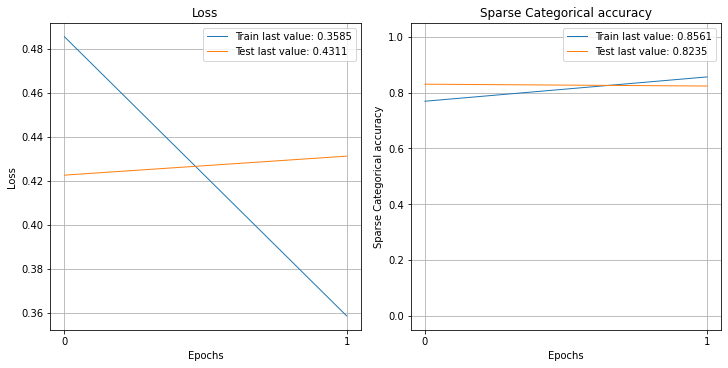

In [111]:
plot_history(history)
plt.show()

<p style="font-size : 16px"> As can be clearly seen, we have achieved a significant leap in model quality.</p>

<font size="+1" color="grey"><b>4.3 Submission BERT Model</b></font><br><a id="4.3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [112]:
length = max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [113]:
input_ids_te, attention_mask_te = prepareBERT(length, te)
input_ids_tr, attention_mask_tr = prepareBERT(length, tr, y)

3263
3263
7613
7613
7613


In [114]:
bert_model.compile(
    loss = loss, 
    optimizer = optimizer, 
    metrics = SparseCategoricalAccuracy()
)
bert_model.trainable = True
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_43 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [115]:
history = bert_model.fit(
    [input_ids_tr,attention_mask_tr],
    y,
    batch_size = 48,
    epochs = 2
)

Epoch 1/2
159/159 [==============================] - 226s 1s/step - loss: 0.3158 - sparse_categorical_accuracy: 0.8781
Epoch 2/2
159/159 [==============================] - 215s 1s/step - loss: 0.2475 - sparse_categorical_accuracy: 0.9052


In [116]:
Predictions = bert_model.predict(
   [input_ids_te, attention_mask_te],
    batch_size = 48
)

<p style="font-size : 16px"> Since we use logits, we only need to convert them to probabilities with either with logit or with softmax.</p>

$$ probabilities \ class_1 = \frac{1}{1+e^{-class_1}} $$

$$ probabilities \ class_1  = \frac{e^{class_1}}{e^{class_1}+e^{class_2}} $$
``` Logit = [1/(1+np.exp(-i[1])) for i in Predictions[0]]  ```

``` Softmax = [i[1] for i in softmax(Predictions[0]).numpy().tolist()]  ```

In [117]:
Predictions = [i[1] for i in softmax(Predictions[0]).numpy().tolist()]

<p style="font-size : 16px">Compare the distribution of the BERT predictions with the baseline:</p>

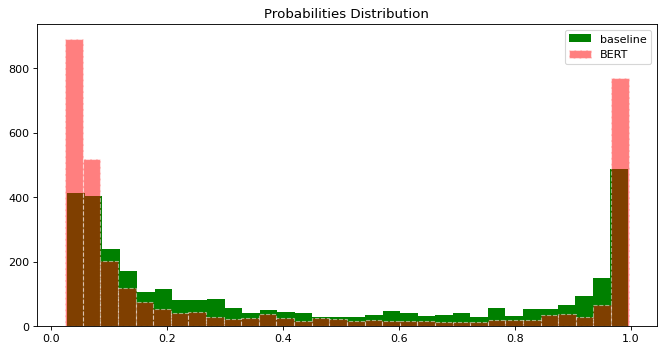

In [118]:
comHist(baseline, Predictions, "BERT")

In [119]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0


In [120]:
subm.to_csv("Submission_BERT.csv", index=False)

In [121]:
# colors = np.array(Image.open("../input/imagesforkernels/BERT-subm.JPG"))
# width = colors.shape[1]
# height = colors.shape[0]
# plt.figure(figsize = (2, 3))
# plt.axis('off')
# plt.imshow(colors)
# plt.show()

FileNotFoundError: ignored

<font size="+3" color="grey"><b>5. Voting</b></font><br><a id="5"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px"> Now, we mix all models to one model to increase performance. This is possible because high variances of the learned hypotheses are thereby averaged out. </p>

In [123]:
s1 = pd.read_csv("./Submission_Basic.csv")
s2 = pd.read_csv("./Submission_W2V.csv")
s3 = pd.read_csv("./Submission_W2V_Embed.csv")
s4 = pd.read_csv("./Submission_BERT.csv")

subm = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing_with_Disaster_Tweets/Dataset/sample_submission.csv")

Voting = np.where(s1.target + s2.target + s3.target + s4.target + s4.target >= 3, 1, 0)

subm["target"] = Voting
subm.head(7)

subm.to_csv("Submission_Voting.csv", index=False)

<font size="+3" color="grey"><b>6. Conclusion</b></font><br><a id="6"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">NLP is probably the area where the greatest technical progress has been made in recent years. Often the models can be used in a completely different context. The transformer technology with the multi-head self attention has made a visible breakthrough. You can see in this tutorial how easy it has become to apply a simple text classification with a Transformer model. If you know just a little bit of programming, you are now able to solve even quite difficult text-based problems individually to acceptable solutions. Also word embeddings bring a performance increase, compared to the base model. </p>

### <center>If you like the kernel, give it an upvote:</center>
<center><a href="#top" class="btn-lg btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a></center>

In [ ]:
4